# Buying on Emotion
### An attempt on predicting market trends based on the emotions from Twitter users

In this notebook I will try to see if a model can predict an increase in the open price of the SPY etf based on emotional data from twitter. The assumption I am testing, is that happier people tend to have a higher outlook on the next day, thus they may be more likey to invest or trade. 

Ideally, our model should preform better than 50% accuracy (random guess). 

In [77]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score
import seaborn as sns
import datetime as dt

import warnings
warnings.filterwarnings("ignore")

## Collecting Data
Data will be collected from two sources. The first source will be hedonometer data, this data is created based on the "happiness" of the words in tweets in the US, and also how many words were tweeted that day as "frequency". It can also track happiness in parallel with major events, but I will not be using that data. 

If you are interested here is the link to the website: https://hedonometer.org/timeseries/en_all/?from=2020-02-06&to=2021-08-05

I will also be using SPY etf data. This is data based on the SP 500 US stock data. I will be collecting the "Close/Last", "Open", "Volume", "High", and "Low". In this initial example I will be just be using the difference in the "Open" price from one day to the next (this will be calcuated separately later). 


In [78]:
# getting data from both SPI and from twitter website. 
# First lets get twitter website data 
import requests
import json
uri = 'http://hedonometer.org/api/v1/happiness/?format=json&timeseries__title=en_all&date__gte=2019-01-01&limit=1000'
r = requests.get(uri)
twitter_emotions_df = pd.DataFrame(json.loads(r.content)['objects'])
twitter_emotions_df.sort_values('date', inplace=True)
twitter_emotions_df.head()

,date,frequency,happiness,timeseries
37,2019-01-01,145361578.0,6.095,/api/v1/timeseries/3/
38,2019-01-02,156353260.0,6.007,/api/v1/timeseries/3/
39,2019-01-03,161389001.0,6.002,/api/v1/timeseries/3/
40,2019-01-04,163318124.0,5.983,/api/v1/timeseries/3/
41,2019-01-05,159511070.0,5.984,/api/v1/timeseries/3/


In [79]:
# getting spi data
spy_data_read_df = pd.read_csv("spy_data.csv")
spy_data_read_df = spy_data_read_df.iloc[::-1]
spy_data_read_df.reset_index(inplace=True)
spy_data_df = spy_data_read_df.copy()
spy_data_df.drop(columns=['index'], inplace=True)
spy_data_df.head()

,Date,Close/Last,Volume,Open,High,Low
0,08/04/2016,216.4097,46454000,216.31,216.7800,214.25
1,08/05/2016,218.1800,71799630,217.21,218.2300,217.07
2,08/08/2016,218.0500,39681420,218.40,218.5200,217.74
3,08/09/2016,218.1800,51073070,218.13,218.7600,217.80
4,08/10/2016,217.6400,57758740,218.31,218.4038,217.23


## Exploring Data
In this section I will be seeing what a few of the databases look like. Try to see any intial trends, and predict any future pitfalls. 


<AxesSubplot:title={'center':'Word count per date'}, xlabel='date'>

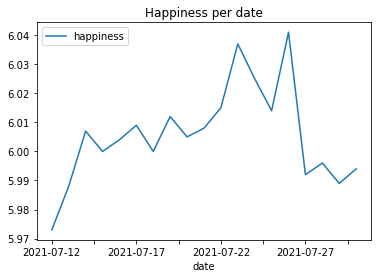

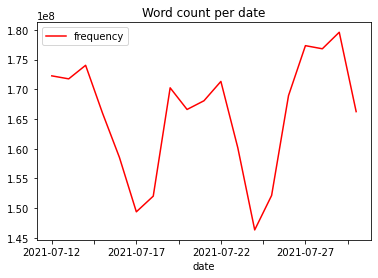

In [84]:
#twitter data exploration
# what does the data look like?
twitter_preview = twitter_emotions_df[-20:-1]
twitter_preview['happiness'] = twitter_preview['happiness'].astype(float)
twitter_preview.plot(x='date', y='happiness', title='Happiness per date')
twitter_preview.plot(x='date', y='frequency', color='red', title='Word count per date')

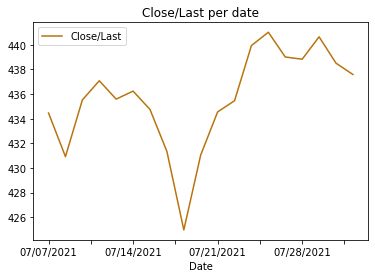

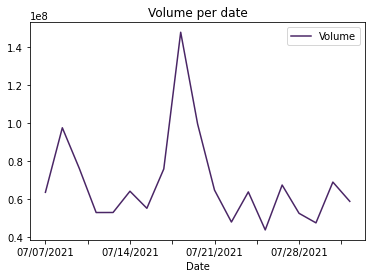

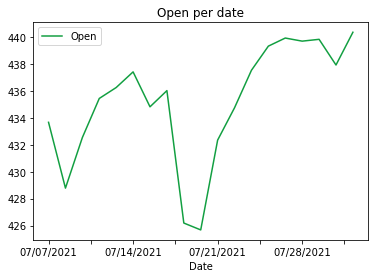

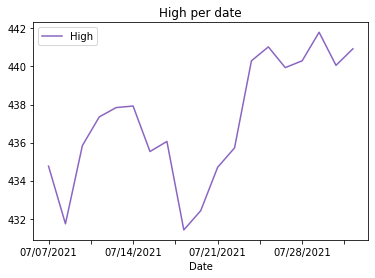

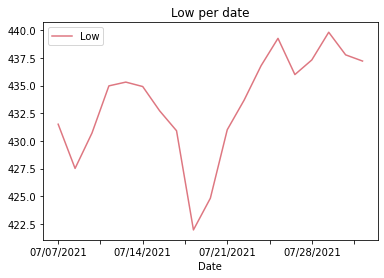

In [5]:
# now lets look at spy data
spy_preview = spy_data_df[-20:-1]
for column in spy_preview.columns[1:]:
    color_pick = "#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)])
    spy_preview.plot(x=spy_preview.columns[0], y=column, title=f'{column} per date', color=color_pick)



## Cleaning Data 

After looking at my data a bit, I noticed that the twitter data only goes as far back as the beginning of 2019. This is important since the SPY data goes back futher than 2012! 

Since we are looking at predicting SPY data changes, we will clean up the SPY data to only have 2019 forward. 

You may also notice that some dates are missing from the SPY data. This is because the market is closed on weekends and on holidays. However since we only need to predict an increase in the next market day, we can leave all the twitter data, as over the weekend an event in real life may spark a lot of twitter activity which may effect the opening prices of SPY.

In [76]:
# twitter data only goes back to 2019, need to keep that in mind 
index_spy_2019_start = spy_data_df[spy_data_df['Date'] == '01/02/2019'].index.values # market is closed on new years
spy_2019_beyond_data_df = spy_data_df.iloc[int(index_spy_2019_start):-1]
spy_2019_beyond_data_df = spy_2019_beyond_data_df.reset_index()
spy_2019_beyond_data_df.drop(columns = ['index'], inplace=True)
spy_2019_beyond_data_df.head()


,Date,Close/Last,Volume,Open,High,Low
0,01/02/2019,250.18,126041700,245.98,251.21,245.95
1,01/03/2019,244.21,142029300,248.23,248.57,243.67
2,01/04/2019,252.39,142444500,247.59,253.11,247.17
3,01/07/2019,254.38,102307400,252.69,255.95,251.69
4,01/08/2019,256.77,101804900,256.82,257.31,254.00


## Peparing Data

Since I am using the previous N days of twitter emotion data to predict a spy day, I need to create a function that will give me the N previous days based on a date passed in. 

I also will create a simliar fucntion for the SPY dates too if I ever want to expand using SPY trends in my model as well. 

It is also necessary to create an output dataframe that records the differences in a SPY output from the previous open market day. In this case I am using the "Open" output. Once I get that difference, I need to determine if that is an upward trend or not. Since I have the actual difference and the trend, I will make both accessible, incase later we train models to actually predict the monetary amount too. 

In [7]:
# Now we want to prepare our data
def get_twitter_days(twitter_data_df, date, num_days=5):
    date = date.strftime("%Y-%m-%d")
    twitter_d = twitter_data_df.reset_index()
    index_date_twitter = twitter_d[twitter_d['date'] == date].index.values
    assert len(index_date_twitter) != 0, f"The twitter date: {date} does not exist."
    index_date_twitter = int(index_date_twitter)
    twitter_dates_df = twitter_data_df[index_date_twitter-num_days+1:index_date_twitter+1]
    #twitter_dates_df.drop(columns = ['index'], inplace =True)
    return twitter_dates_df

d = dt.datetime(2019, 8, 2)
test_tw = get_twitter_days(twitter_emotions_df, d, 5)
print(test_tw.head(10))
# looks like it works!


,date,frequency,happiness,timeseries
231,2019-07-29,178275397.0,5.924,/api/v1/timeseries/3/
232,2019-07-30,181534815.0,5.947,/api/v1/timeseries/3/
233,2019-07-31,174871449.0,5.946,/api/v1/timeseries/3/
234,2019-08-01,170821458.0,5.980,/api/v1/timeseries/3/
235,2019-08-02,162774205.0,5.963,/api/v1/timeseries/3/


In [8]:
# do same thing for getting spy day 
def get_spy_days(spy_data_df, date, num_days=1):
    date = date.strftime("%m/%d/%Y")
    spy_d = spy_data_df.reset_index()
    index_date_spy = spy_d[spy_d['Date'] == date].index.values
    assert len(index_date_spy) != 0, f"The spy date: {date} does not exist."
    index_date_spy = int(index_date_spy)
    spy_dates_df = spy_data_df[index_date_spy-num_days+1:index_date_spy+1]
    return spy_dates_df

d = dt.datetime(2020, 2, 3)
test_spy = get_spy_days(spy_2019_beyond_data_df, d, 3)
test_spy.head()
    

,Date,Close/Last,Volume,Open,High,Low
271,01/30/2020,327.68,75491840,324.36,327.91,323.54
272,01/31/2020,321.73,113845600,327.00,327.17,320.73
273,02/03/2020,324.12,69242290,323.35,326.16,323.22


In [85]:
# now since we want the next days data we need to build a data set that holds the difference between two days. 
def get_spy_diff_data(spy_data, column_name='Close/Last'):
    difference = pd.DataFrame(spy_data['Date'][1:-1]).reset_index()
    temp1 = spy_data[column_name][1:].reset_index()
    temp2 = spy_data[column_name][0:-1].reset_index()
    diff = temp1-temp2
    diff.drop(columns = ['index'], inplace=True)
    difference['diff'] = diff
    difference['upward'] = difference['diff'] > 0
    difference.drop(columns = ['index'], inplace=True)
    return difference

difference_data = get_spy_diff_data(spy_2019_beyond_data_df, 'High')
difference_data.head()
# looks like it worked!

,Date,diff,upward
0,01/03/2019,-2.64,False
1,01/04/2019,4.54,True
2,01/07/2019,2.84,True
3,01/08/2019,1.36,True
4,01/09/2019,1.60,True


### A major challenge
One major challenge with this data was trying to organize the data into the format of a training set. 
Below I grab "num_days" number of days and create a dataframe that stores the happiness and frequency of each day. One issue that popped up is that if I grab 5 days right at the SPY date of 01/02/2019, I run out of twitter data. Now, I could have filled it in with the average, but instead I had the data automatically exclude SPY dates if I could not get all "num_days" from the twitter data. 

I also went back and decided to use datetimes to store date values for consistency.

In [86]:
# next we want to set up our data set 
def get_X_y(twitter_data, spy_data, num_days = 5, preditct_column ='Open', output='upward'):
    # get twitter data based on spy date
    # arrange it into rows (reshape)
    # add hapiness, add frequency, and add change 
    # repeat above for all dates! 
    # lets just go through each column 
    twitter_first_date = dt.datetime(2019, 1, 1)
    date_list = spy_data['Date'].tolist()
    # check date and nums look right 
    d = dt.datetime.strptime(date_list[0], '%m/%d/%Y')
    if(d - dt.timedelta(days=num_days+1) < twitter_first_date ):
            print("Could not reach far back as {} on twitter data".format(d - dt.timedelta(days=num_days+1)))
            date_list = date_list[num_days + 1:-1]
            print("You list will now start at: {}".format(date_list[0]))
            pass
    X = pd.DataFrame(index = range(0, num_days*2))
    for date in date_list:
        d = dt.datetime.strptime(date, '%m/%d/%Y')
        d_before = d - dt.timedelta(days=1)
        tw_pre_data = get_twitter_days(twitter_data, d_before, num_days)
        tw_pre_data.reset_index(inplace=True)
        X[date] = pd.concat([tw_pre_data['happiness'], tw_pre_data['frequency']], ignore_index=True)
    X = X.T
    # X is made
    y_pre = get_spy_diff_data(spy_data, 'Open')
    y_pre_index_start = int(y_pre[y_pre['Date'] == date_list[0]].index.values)
    y_pre.reset_index(inplace = True)
    y = y_pre[y_pre_index_start:]
    y.set_index(y['Date'], inplace=True)
    #y = pd.concat([y, y_pre[output][y_pre_index_start:]], ignore_index=True)
    return X, pd.Series(y[output])

X, y = get_X_y(twitter_emotions_df, spy_2019_beyond_data_df, 30)

    

Could not reach far back as 2018-12-02 00:00:00 on twitter data
You list will now start at: 02/15/2019


In [92]:
def prepare_data(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, test_size=0.15)
    return X_train, X_test, y_train, y_test

## Training the Model 
Here I get a base line accuracy using the LogisticRegression model. And already we are at a great start! We are better than guessing!

In [93]:
def train_model(model, X_train, y_train, X_test, y_test, parameters={}):
    model_UT = model
    cf = GridSearchCV(model_UT, param_grid=parameters, scoring='accuracy', cv=5)
    cf.fit(X_train, y_train)
    best_model = cf.best_estimator_
    best_score = cf.best_score_
    best_params = cf.best_params_
    return best_model, best_score, best_params
    
    

In [94]:
X, y = get_X_y(twitter_emotions_df, spy_2019_beyond_data_df, 10)
X_train, X_test, y_train, y_test = prepare_data(X, y)
mod = LogisticRegression(random_state=0)
print(train_model(mod, X_train, y_train, X_test, y_test))

Could not reach far back as 2018-12-22 00:00:00 on twitter data
You list will now start at: 01/17/2019
(LogisticRegression(random_state=0), 0.5984709480122324, {})


   ## Optimization

For the models to train I wanted to try 3 classic classifer models, LogisticRegression, DecsionTreeClassifer, and a RandomForestClassifer. 

I optimized the model based on some partially arbitary parameters. I also optimized it for the number of twitter days. 

In [95]:
# go through each model type for different days and with different parameters
best_models = []
best_scores = []
best_params = []
models = [LogisticRegression(random_state=0), DecisionTreeClassifier(random_state=0), RandomForestClassifier(random_state=0) ]
model_params = [{"solver":["newton-cg", "liblinear", "sag", "saga", "lbfgs"]},
                {"min_samples_split" : [5, 10, 15, 20, 25], 'max_depth':[None, 5, 10, 15], 'min_samples_leaf': [1, 3, 5, 10, 15]}, 
                {"n_estimators" : [25, 50, 60], 'max_depth':[None, 5, 10], 'min_samples_leaf': [1, 3, 5, 10, 15]}]

for num_days in range(5, 25):
    X, y = get_X_y(twitter_emotions_df, spy_2019_beyond_data_df, num_days)
    X_train, X_test, y_train, y_test = prepare_data(X, y)
    for ind, model in enumerate(models):
        m1, s1, p1 =train_model(model, X_train, y_train, X_test, y_test, model_params[ind])
        best_models.append(m1)
        best_scores.append(s1)
        best_params.append(p1)
        best_num_days = num_days
best_score_index = best_scores.index(max(best_scores))
best_score = max(best_scores)
best_model = best_models[best_score_index]
best_param = best_params[best_score_index]
print("Best score: ", best_score, " with best model: ", best_model, "using number of days: ", best_num_days)

Could not reach far back as 2018-12-27 00:00:00 on twitter data
You list will now start at: 01/10/2019
Could not reach far back as 2018-12-26 00:00:00 on twitter data
You list will now start at: 01/11/2019
Could not reach far back as 2018-12-25 00:00:00 on twitter data
You list will now start at: 01/14/2019
Could not reach far back as 2018-12-24 00:00:00 on twitter data
You list will now start at: 01/15/2019
Could not reach far back as 2018-12-23 00:00:00 on twitter data
You list will now start at: 01/16/2019
Could not reach far back as 2018-12-22 00:00:00 on twitter data
You list will now start at: 01/17/2019
Could not reach far back as 2018-12-21 00:00:00 on twitter data
You list will now start at: 01/18/2019
Could not reach far back as 2018-12-20 00:00:00 on twitter data
You list will now start at: 01/22/2019
Could not reach far back as 2018-12-19 00:00:00 on twitter data
You list will now start at: 01/23/2019
Could not reach far back as 2018-12-18 00:00:00 on twitter data
You list 

In [106]:
print("Best Model: ", best_model)
print("Accuracy: ", best_score)
print("Num of Days: ", best_num_days)

Best Model:  RandomForestClassifier(max_depth=5, min_samples_leaf=15, n_estimators=50,
                       random_state=0)
Accuracy:  0.6298844716275909


NameError: name 'best_num_days' is not defined

In [107]:

X, y = get_X_y(twitter_emotions_df, spy_2019_beyond_data_df, 10)
X_train, X_test, y_train, y_test = prepare_data(X, y)
preds = best_model.predict(X_test)
print("Best Model: ", best_model)
print("Accuracy: ", accuracy_score(y_test, preds))

Could not reach far back as 2018-12-22 00:00:00 on twitter data
You list will now start at: 01/17/2019
Best Model:  RandomForestClassifier(max_depth=5, min_samples_leaf=15, n_estimators=50,
                       random_state=0)
Accuracy:  0.5104166666666666


## Results
Well... we got 51% accuracy! Better than guessing (I guess), but not really that great. 

Some pitfalls that may have occurred:
- The difference in the happiness range and frequency range are huge! 
    - Could have normalized the data to possibly improve accuracy
- Could have made more educated choices for which parameters to test
- Could use "Reoccuring Time" models that specialize in tying metrics to dates
- Likley could have some overfitting still, it is possible the RandomForestClassifier model we picked has too much depth and not enough minimum samples per leaf. 
- Stocks are notoriously hard to predict 


## Citation:
SPY Data from: https://www.nasdaq.com/market-activity/funds-and-etfs/spy/historical

Twitter Happiness Data From: 

@Misc{dodds2014a,
  author = 	 {Dodds, P. S. and Clark, E. M. and Desu, S. and Frank, M. R. and Reagan, A. J. and  Williams, J. R. and Mitchell, L. and Harris, K. D. and Kloumann, I. M. and Bagrow, J. P. and Megerdoomian, K. and McMahon, M. T. and Tivnan, B. F. and Danforth, C. M.},
  title = 	 {Human language reveals a universal positivity bias},
  OPThowpublished = {},
  OPTmonth = 	 {},
  year = 	 {2014},
  note = 	 {Preprint available at \href{http://arxiv.org/abs/1406.3855}{http://arxiv.org/abs/1406.3855}},
  OPTannote = 	 {}
}


